# Benchmarking Stop Detection Algorithms

This notebook compares the performance of four stop detection algorithms: **Lachesis**, **TA-DBSCAN**, **Grid-Based**, and **HDBSCAN**. We evaluate both overall runtime on a full trajectory dataset and how runtime scales with increasing data size.

## Setup

In [1]:
import time
import warnings
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nomad.io.base as loader
import nomad.filters as filters
from nomad.stop_detection.viz import plot_pings, plot_stops, plot_time_barcode, plot_stops_barcode, clip_spatial_outliers
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.stop_detection.hdbscan as HDBSCAN

city = gpd.read_file("../../examples/garden_city.geojson")
traj = loader.sample_from_file('../../examples/gc_data/', users=['youthful_mayer'], format='csv')

## Overall Runtime Comparison

We first measure the total execution time for each algorithm on the complete dataset.

In [2]:
algorithms = [
    ('Lachesis', lambda t: LACHESIS.lachesis(t, delta_roam=20, dt_max=60, dur_min=5, 
                                              complete_output=True, keep_col_names=True,
                                              latitude="latitude", longitude="longitude")),
    ('TA-DBSCAN', lambda t: DBSCAN.ta_dbscan(t, time_thresh=240, dist_thresh=15, min_pts=3, 
                                              dur_min=5, complete_output=True,
                                              latitude="latitude", longitude="longitude")),
    ('Grid-Based', lambda t: GRID_BASED.grid_based(
        t.assign(h3_cell=filters.to_tessellation(t, index="h3", res=10, 
                                                  latitude='latitude', longitude='longitude', 
                                                  data_crs='EPSG:4326')),
        time_thresh=240, complete_output=True, timestamp='timestamp', location_id='h3_cell')),
    ('HDBSCAN', lambda t: HDBSCAN.st_hdbscan(t, time_thresh=240, min_pts=3, min_cluster_size=2, 
                                              dur_min=5, complete_output=True,
                                              latitude="latitude", longitude="longitude"))
]

results = []
for name, func in algorithms:
    t0 = time.time()
    stops_output = func(traj)
    results.append({'Algorithm': name, 'Runtime (s)': time.time() - t0})
    if name == 'Lachesis':
        stops = stops_output

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Algorithm  Runtime (s)
  Lachesis     1.060303
 TA-DBSCAN     6.314632
Grid-Based     0.207118
   HDBSCAN    12.504672


## Visualization

Spatial and temporal visualization of detected stops using the Lachesis algorithm.

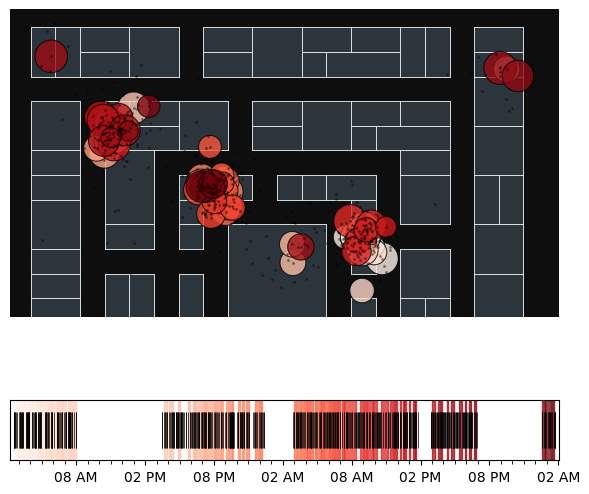

In [3]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6, 6.5),
                                         gridspec_kw={'height_ratios': [10, 1]})

two_days = 1704162819 + 3600*48
traj_subset = traj[traj['timestamp'] <= two_days]
stops_subset = stops[stops['end_timestamp'] <= two_days]
traj_clean = clip_spatial_outliers(traj_subset, latitude='latitude', longitude='longitude')

plot_pings(traj_clean, ax=ax_map, color='black', s=1.5, alpha=0.3, 
           base_geometry=city, latitude='latitude', longitude='longitude')
plot_stops(stops_subset, ax=ax_map, cmap='Reds', base_geometry=city,
           latitude='latitude', longitude='longitude', radius=stops_subset["diameter"]/2)
plot_time_barcode(traj_subset['timestamp'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_subset, ax=ax_barcode, cmap='Reds', set_xlim=False, timestamp='timestamp')
plt.tight_layout()
plt.show()

## Runtime Scalability

We measure how runtime scales with dataset size by running each algorithm on progressively larger time windows (6-hour increments).

In [4]:
runtime_data = []
for current_end in pd.date_range(start=traj['datetime'].min() + pd.Timedelta(hours=6),
                                 end=traj['datetime'].max(),
                                 freq='6h'):
    window = traj[traj['datetime'] <= current_end]
    n_pings = len(window)
    
    for name, func in algorithms:
        t0 = time.time()
        func(window)
        runtime_data.append({'Algorithm': name, 'n_pings': n_pings, 'runtime': time.time() - t0})

runtime_df = pd.DataFrame(runtime_data)

## Performance Comparison

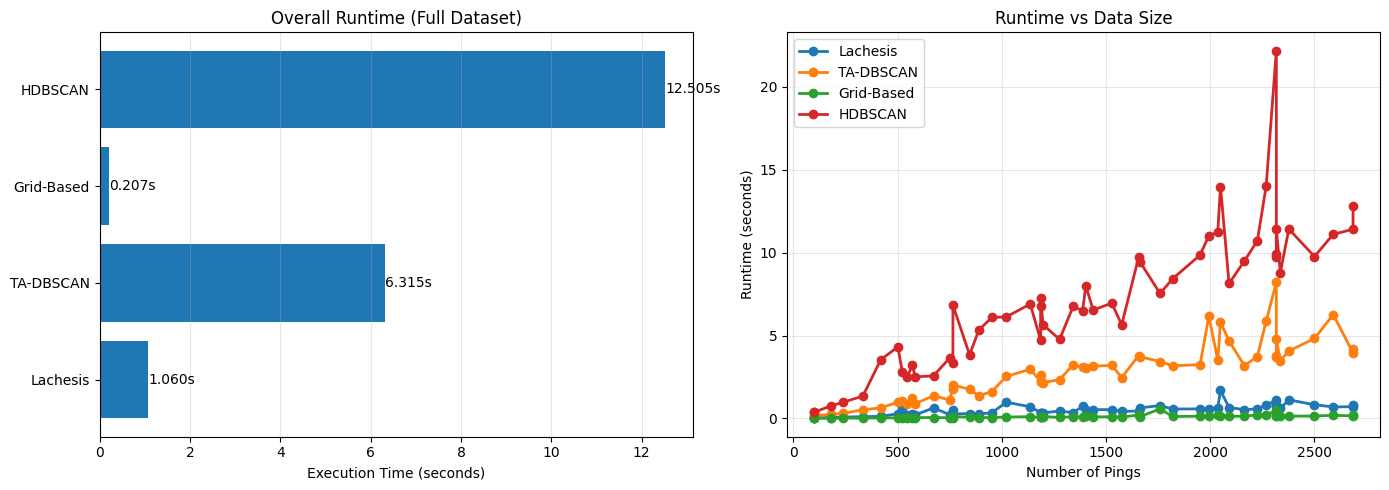

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

bars = ax1.barh(results_df['Algorithm'], results_df['Runtime (s)'])
ax1.set_xlabel('Execution Time (seconds)')
ax1.set_title('Overall Runtime (Full Dataset)')
ax1.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, results_df['Runtime (s)']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}s', va='center')

for algo in runtime_df['Algorithm'].unique():
    subset = runtime_df[runtime_df['Algorithm'] == algo]
    ax2.plot(subset['n_pings'], subset['runtime'], marker='o', label=algo, linewidth=2)

ax2.set_xlabel('Number of Pings')
ax2.set_ylabel('Runtime (seconds)')
ax2.set_title('Runtime vs Data Size')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()